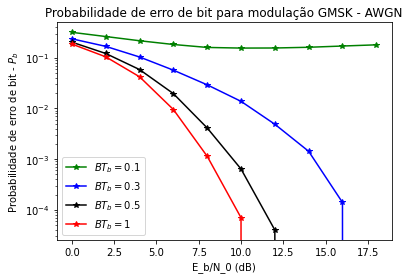

In [ ]:
#gmsk com AWGN
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import matplotlib.pyplot as plt
from scipy.signal import upfirdn,lfilter
from scipy.special import erfc
#bibliotecas retiradas de Digital Comunications with Python
fc = 800
OF = 16 #fator de oversampling
N = 100000 #numero de simbolos a transmitir
L = 4
Tb = 2
a = np.random.randint(2, size=N)
BT = np.linspace(0, 2, num=10)

def gaussianLPF(BT, Tb, L, k):
  """
  Generate filter coefficients of Gaussian low pass filter (used in gmsk_mod)
  Parameters:
  BT : BT product - Bandwidth x bit period
  Tb : bit period
  L : oversampling factor (number of samples per bit)
  k : span length of the pulse (bit interval)
  Returns:
  h_norm : normalized filter coefficients of Gaussian LPF
  """
  B = BT/Tb # bandwidth of the filter
  # truncated time limits for the filter
  t = np.arange(start = -k*Tb, stop = k*Tb + Tb/L, step = Tb/L)
  h = B*np.sqrt(2*np.pi/(np.log(2)))*np.exp(-2 * (t*np.pi*B)**2 /(np.log(2)))
  h_norm=h/np.sum(h)
  return h_norm

# Função da Modulação

def gmsk_mod(a,fc,L,BT,enable_plot=False):
    """
    Function to modulate a binary stream using GMSK modulation
    Parameters:
        BT : BT product (bandwidth x bit period) for GMSK
        a : input binary data stream (0's and 1's) to modulate
        fc : RF carrier frequency in Hertz
        L : oversampling factor
        enable_plot: True = plot transmitter waveforms (default False)
    Returns:
        (s_t,s_complex) : tuple containing the following variables
            s_t : GMSK modulated signal with carrier s(t)
            s_complex : baseband GMSK signal (I+jQ)
    """ 
    fs = L*fc; Ts=1/fs;Tb = L*Ts; # derived waveform timing parameters
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L) #NRZ pulse train c(t)
    
    k=1 # truncation length for Gaussian LPF
    h_t = gaussianLPF(BT,Tb,L,k) # Gaussian LPF with BT=0.25
    b_t = np.convolve(h_t,c_t,'full') # convolve c(t) with Gaussian LPF to get b(t)
    bnorm_t = b_t/max(abs(b_t)) # normalize the output of Gaussian LPF to +/-1
    
    h = 0.5;
    # integrate to get phase information
    phi_t = lfilter(b = [1], a = [1,-1], x = bnorm_t*Ts) * h*np.pi/Tb 
    
    I = np.cos(phi_t)
    Q = np.sin(phi_t) # cross-correlated baseband I/Q signals
    
    s_complex = I - 1j*Q # complex baseband representation
    t = Ts* np.arange(start = 0, stop = len(I)) # time base for RF carrier
    sI_t = I*np.cos(2*np.pi*fc*t); sQ_t = Q*np.sin(2*np.pi*fc*t)
    s_t = sI_t - sQ_t # s(t) - GMSK with RF carrier
    
    if enable_plot:
        fig, axs = plt.subplots(2, 4)
        axs[0,0].plot(np.arange(0,len(c_t))*Ts,c_t);
        axs[0,0].set_title('c(t)');axs[0,0].set_xlim(0,40*Tb)
        axs[0,1].plot(np.arange(-k*Tb,k*Tb+Ts,Ts),h_t);
        axs[0,1].set_title('$h(t): BT_b$='+str(BT))
        axs[0,2].plot(t,I,'--');axs[0,2].plot(t,sI_t,'r');
        axs[0,2].set_title('$I(t)cos(2 \pi f_c t)$');axs[0,2].set_xlim(0,10*Tb)
        axs[0,3].plot(t,Q,'--');axs[0,3].plot(t,sQ_t,'r');
        axs[0,3].set_title('$Q(t)sin(2 \pi f_c t)$');axs[0,3].set_xlim(0,10*Tb)
        axs[1,0].plot( np.arange(0,len(bnorm_t))*Ts,bnorm_t);
        axs[1,0].set_title('b(t)');axs[1,0].set_xlim(0,40*Tb)
        axs[1,1].plot(np.arange(0,len(phi_t))*Ts, phi_t);
        axs[1,1].set_title('$\phi(t)$')
        axs[1,2].plot(t,s_t);axs[1,2].set_title('s(t)');
        axs[1,2].set_xlim(0,20*Tb)
        axs[1,3].plot(I,Q);axs[1,3].set_title('Constelação')
        fig.show()        
    return (s_t,s_complex)

def BER(x,b):                   #cálculo da ber
  numErr = np.sum(abs(x - b))
  return numErr/len(x)

def awgn(s,SNRdB,L=1):          #cálculo do awgn
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
        
    N0=P/gamma # Find the noise spectral density    
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal    
    return r
# Função da Demodulação
def gmsk_demod(r_complex,L):            #demodulação GMSK
  """
  Function to demodulate a baseband GMSK signal
  Parameters:
  r_complex : received signal at receiver front end (complex form - I+jQ)
  L : oversampling factor
  Returns:
  a_hat : detected binary stream
  """
  I = np.real(r_complex); Q = -np.imag(r_complex); # I,Q streams
  z1 = Q * np.hstack((np.zeros(L), I[0:len(I)-L]))
  z2 = I * np.hstack((np.zeros(L), Q[0:len(I)-L]))
  z = z1 - z2
  a_hat = (z[2*L-1:-L:L] > 0).astype(int) # sampling and hard decision
  #sampling indices depend on the truncation length (k) of Gaussian LPF defined in the modulator
  return a_hat

EbN0dB = np.arange(start=0,stop = 19, step = 2) # range eb/n0 pra simulação
BTs = [0.1, 0.3 ,0.5, 1] # valores de BT pra o filtro gaussiano

fig, axs = plt.subplots(nrows=1,ncols = 1)
lineColors = ['g','b','k','r']

for i,BT in enumerate(BTs):
  a = np.random.randint(2, size=N) # simbolos 0 ou 1
  (s_t,s_complex) = gmsk_mod(a,fc,L,BT) # modulação gmsk
  BER = np.zeros(len(EbN0dB)) # pra cada eb/n0, valores de ber.
  for j,EbN0 in enumerate(EbN0dB):
    r_complex = awgn(s_complex,EbN0) # canal awgn
    a_hat = gmsk_demod(r_complex,L) # demodulação banda básica
    BER[j] = np.sum(a!=a_hat)/N # computação da ber

  axs.semilogy(EbN0dB,BER,lineColors[i]+'*-',label='$BT_b=$'+str(BT)) #plot

axs.set_title('Probabilidade de erro de bit para modulação GMSK - AWGN')
axs.set_xlabel('E_b/N_0 (dB)');axs.set_ylabel('Probabilidade de erro de bit - $P_b$')
axs.legend();fig.show()


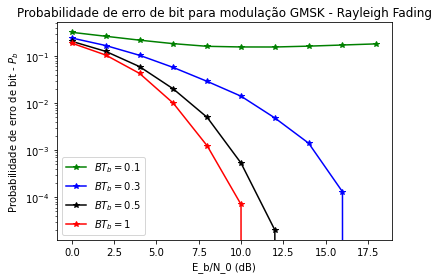

In [ ]:
#gmsk com rayleigh fading
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import matplotlib.pyplot as plt
from scipy.signal import upfirdn,lfilter
from scipy.special import erfc

fc = 800
OF = 16
N = 100000
L = 4
Tb = 2
a = np.random.randint(2, size=N)
BT = np.linspace(0, 2, num=10)

def rayleighFading(N):
    """
    Generate Rayleigh flat-fading channel samples
    Parameters:
        N : number of samples to generate
    Returns:
        abs_h : Rayleigh flat fading samples
    """
    # 1 tap complex gaussian filter
    h = 1/sqrt(2)*(standard_normal(N)+1j*standard_normal(N))
    return h

def gaussianLPF(BT, Tb, L, k):
  """
  Generate filter coefficients of Gaussian low pass filter (used in gmsk_mod)
  Parameters:
  BT : BT product - Bandwidth x bit period
  Tb : bit period
  L : oversampling factor (number of samples per bit)
  k : span length of the pulse (bit interval)
  Returns:
  h_norm : normalized filter coefficients of Gaussian LPF
  """
  B = BT/Tb # bandwidth of the filter
  # truncated time limits for the filter
  t = np.arange(start = -k*Tb, stop = k*Tb + Tb/L, step = Tb/L)
  h = B*np.sqrt(2*np.pi/(np.log(2)))*np.exp(-2 * (t*np.pi*B)**2 /(np.log(2)))
  h_norm=h/np.sum(h)
  return h_norm

# Função da Modulação

def gmsk_mod(a,fc,L,BT,enable_plot=False):
    """
    Function to modulate a binary stream using GMSK modulation
    Parameters:
        BT : BT product (bandwidth x bit period) for GMSK
        a : input binary data stream (0's and 1's) to modulate
        fc : RF carrier frequency in Hertz
        L : oversampling factor
        enable_plot: True = plot transmitter waveforms (default False)
    Returns:
        (s_t,s_complex) : tuple containing the following variables
            s_t : GMSK modulated signal with carrier s(t)
            s_complex : baseband GMSK signal (I+jQ)
    """ 
    fs = L*fc; Ts=1/fs;Tb = L*Ts; # derived waveform timing parameters
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L) #NRZ pulse train c(t)
    
    k=1 # truncation length for Gaussian LPF
    h_t = gaussianLPF(BT,Tb,L,k) # Gaussian LPF with BT=0.25
    b_t = np.convolve(h_t,c_t,'full') # convolve c(t) with Gaussian LPF to get b(t)
    bnorm_t = b_t/max(abs(b_t)) # normalize the output of Gaussian LPF to +/-1
    
    h = 0.5;
    # integrate to get phase information
    phi_t = lfilter(b = [1], a = [1,-1], x = bnorm_t*Ts) * h*np.pi/Tb 
    
    I = np.cos(phi_t)
    Q = np.sin(phi_t) # cross-correlated baseband I/Q signals
    
    s_complex = I - 1j*Q # complex baseband representation
    t = Ts* np.arange(start = 0, stop = len(I)) # time base for RF carrier
    sI_t = I*np.cos(2*np.pi*fc*t); sQ_t = Q*np.sin(2*np.pi*fc*t)
    s_t = sI_t - sQ_t # s(t) - GMSK with RF carrier
    
    if enable_plot:
        fig, axs = plt.subplots(2, 4)
        axs[0,0].plot(np.arange(0,len(c_t))*Ts,c_t);
        axs[0,0].set_title('c(t)');axs[0,0].set_xlim(0,40*Tb)
        axs[0,1].plot(np.arange(-k*Tb,k*Tb+Ts,Ts),h_t);
        axs[0,1].set_title('$h(t): BT_b$='+str(BT))
        axs[0,2].plot(t,I,'--');axs[0,2].plot(t,sI_t,'r');
        axs[0,2].set_title('$I(t)cos(2 \pi f_c t)$');axs[0,2].set_xlim(0,10*Tb)
        axs[0,3].plot(t,Q,'--');axs[0,3].plot(t,sQ_t,'r');
        axs[0,3].set_title('$Q(t)sin(2 \pi f_c t)$');axs[0,3].set_xlim(0,10*Tb)
        axs[1,0].plot( np.arange(0,len(bnorm_t))*Ts,bnorm_t);
        axs[1,0].set_title('b(t)');axs[1,0].set_xlim(0,40*Tb)
        axs[1,1].plot(np.arange(0,len(phi_t))*Ts, phi_t);
        axs[1,1].set_title('$\phi(t)$')
        axs[1,2].plot(t,s_t);axs[1,2].set_title('s(t)');
        axs[1,2].set_xlim(0,20*Tb)
        axs[1,3].plot(I,Q);axs[1,3].set_title('Constelação')
        fig.show()        
    return (s_t,s_complex)

def BER(x,b):                   #função da ber
  numErr = np.sum(abs(x - b))
  return numErr/len(x)

def awgn(s,SNRdB,L=1):         #canal awgn
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
        
    N0=P/gamma # Find the noise spectral density    
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal    
    return r
# Função da Demodulação
def gmsk_demod(r_complex,L):
  """
  Function to demodulate a baseband GMSK signal
  Parameters:
  r_complex : received signal at receiver front end (complex form - I+jQ)
  L : oversampling factor
  Returns:
  a_hat : detected binary stream
  """
  I = np.real(r_complex); Q = -np.imag(r_complex); # I,Q streams
  z1 = Q * np.hstack((np.zeros(L), I[0:len(I)-L]))
  z2 = I * np.hstack((np.zeros(L), Q[0:len(I)-L]))
  z = z1 - z2
  a_hat = (z[2*L-1:-L:L] > 0).astype(int) # sampling and hard decision
  #sampling indices depend on the truncation length (k) of Gaussian LPF defined in the modulator
  return a_hat

EbN0dB = np.arange(start=0,stop = 19, step = 2) # Eb/N0 range in dB for simulation
BTs = [0.1, 0.3 ,0.5, 1] # Gaussian LPF's BT products
#fc = 800 # Carrier frequency in Hz (must be < fs/2 and > fg)
#L = 16 # oversampling factor

fig, axs = plt.subplots(nrows=1,ncols = 1)
lineColors = ['g','b','k','r']

for i,BT in enumerate(BTs):
  a = np.random.randint(2, size=N) # símbolos 0 ou 1
  (s_t,s_complex) = gmsk_mod(a,fc,L,BT) # modulação gmsk
  BER = np.zeros(len(EbN0dB)) # valores de ber pra cada eb/n0
  for j,EbN0 in enumerate(EbN0dB):
    h = rayleighFading(1)              # criaçao do canal em rayleigh fading
    r_complex = awgn(s_complex*h,EbN0) # awgn
    r_complex = h.conj()/abs(h) ** 2 * r_complex      # equalizador LS
    a_hat = gmsk_demod(r_complex,L) # demodulação em banda básica
    BER[j] = np.sum(a!=a_hat)/N # computação ber
    
  axs.semilogy(EbN0dB,BER,lineColors[i]+'*-',label='$BT_b=$'+str(BT))

axs.set_title('Probabilidade de erro de bit para modulação GMSK - Rayleigh Fading')
axs.set_xlabel('E_b/N_0 (dB)');axs.set_ylabel('Probabilidade de erro de bit - $P_b$')
axs.legend();fig.show()

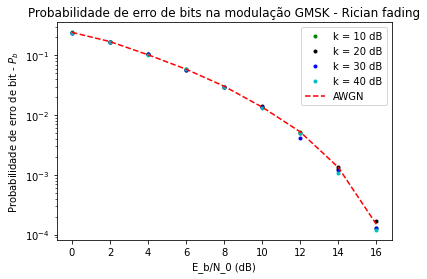

In [ ]:
#gmsk com rician fading
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import matplotlib.pyplot as plt
from scipy.signal import upfirdn,lfilter
from scipy.special import erfc

fc = 800
OF = 16
N = 100000
L = 4
Tb = 2
a = np.random.randint(2, size=N)
BT = np.linspace(0, 2, num=10)

def gaussianLPF(BT, Tb, L, k):                   #filtro gaussiano
  """
  Generate filter coefficients of Gaussian low pass filter (used in gmsk_mod)
  Parameters:
  BT : BT product - Bandwidth x bit period
  Tb : bit period
  L : oversampling factor (number of samples per bit)
  k : span length of the pulse (bit interval)
  Returns:
  h_norm : normalized filter coefficients of Gaussian LPF
  """
  B = BT/Tb # bandwidth of the filter
  # truncated time limits for the filter
  t = np.arange(start = -k*Tb, stop = k*Tb + Tb/L, step = Tb/L)
  h = B*np.sqrt(2*np.pi/(np.log(2)))*np.exp(-2 * (t*np.pi*B)**2 /(np.log(2)))
  h_norm=h/np.sum(h)
  return h_norm

# Função da Modulação

def gmsk_mod(a,fc,L,BT,enable_plot=False):         
    """
    Function to modulate a binary stream using GMSK modulation
    Parameters:
        BT : BT product (bandwidth x bit period) for GMSK
        a : input binary data stream (0's and 1's) to modulate
        fc : RF carrier frequency in Hertz
        L : oversampling factor
        enable_plot: True = plot transmitter waveforms (default False)
    Returns:
        (s_t,s_complex) : tuple containing the following variables
            s_t : GMSK modulated signal with carrier s(t)
            s_complex : baseband GMSK signal (I+jQ)
    """ 
    fs = L*fc; Ts=1/fs;Tb = L*Ts; # derived waveform timing parameters
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L) #NRZ pulse train c(t)
    
    k=1 # truncation length for Gaussian LPF
    h_t = gaussianLPF(BT,Tb,L,k) # Gaussian LPF with BT=0.25
    b_t = np.convolve(h_t,c_t,'full') # convolve c(t) with Gaussian LPF to get b(t)
    bnorm_t = b_t/max(abs(b_t)) # normalize the output of Gaussian LPF to +/-1
    
    h = 0.5;
    # integrate to get phase information
    phi_t = lfilter(b = [1], a = [1,-1], x = bnorm_t*Ts) * h*np.pi/Tb 
    
    I = np.cos(phi_t)
    Q = np.sin(phi_t) # cross-correlated baseband I/Q signals
    
    s_complex = I - 1j*Q # complex baseband representation
    t = Ts* np.arange(start = 0, stop = len(I)) # time base for RF carrier
    sI_t = I*np.cos(2*np.pi*fc*t); sQ_t = Q*np.sin(2*np.pi*fc*t)
    s_t = sI_t - sQ_t # s(t) - GMSK with RF carrier
    
    if enable_plot:
        fig, axs = plt.subplots(2, 4)
        axs[0,0].plot(np.arange(0,len(c_t))*Ts,c_t);
        axs[0,0].set_title('c(t)');axs[0,0].set_xlim(0,40*Tb)
        axs[0,1].plot(np.arange(-k*Tb,k*Tb+Ts,Ts),h_t);
        axs[0,1].set_title('$h(t): BT_b$='+str(BT))
        axs[0,2].plot(t,I,'--');axs[0,2].plot(t,sI_t,'r');
        axs[0,2].set_title('$I(t)cos(2 \pi f_c t)$');axs[0,2].set_xlim(0,10*Tb)
        axs[0,3].plot(t,Q,'--');axs[0,3].plot(t,sQ_t,'r');
        axs[0,3].set_title('$Q(t)sin(2 \pi f_c t)$');axs[0,3].set_xlim(0,10*Tb)
        axs[1,0].plot( np.arange(0,len(bnorm_t))*Ts,bnorm_t);
        axs[1,0].set_title('b(t)');axs[1,0].set_xlim(0,40*Tb)
        axs[1,1].plot(np.arange(0,len(phi_t))*Ts, phi_t);
        axs[1,1].set_title('$\phi(t)$')
        axs[1,2].plot(t,s_t);axs[1,2].set_title('s(t)');
        axs[1,2].set_xlim(0,20*Tb)
        axs[1,3].plot(I,Q);axs[1,3].set_title('Constelação')
        fig.show()        
    return (s_t,s_complex)

def ricianFading(K_dB,N):                              #canal rician fading
    """
    Generate Rician flat-fading channel samples
    Parameters:
        K_dB: Rician K factor in dB scale
        N : number of samples to generate
    Returns:
        abs_h : Rician flat fading samples
    """
    K = 10**(K_dB/10) # K em escala linear
    mu = sqrt(K/(2*(K+1))) # media
    sigma = sqrt(1/(2*(K+1))) # sigma
    h = (sigma*standard_normal(N)+mu)+1j*(sigma*standard_normal(N)+mu)
    return abs(h)

def BER(x,b):                         #cálculo da ber.
  numErr = np.sum(abs(x - b))             
  return numErr/len(x) 

def awgn(s,SNRdB,L=1):                 #awgn
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #escala SNR pra linear
    
    if s.ndim==1:# se s é um vetor unidimensional
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # sinais multidimensionais
        P=L*sum(sum(abs(s)**2))/len(s) # se s é matriz
        
    N0=P/gamma # encontrar densidade espectral do ruído   
    if isrealobj(s):# checar se entrada é real ou não
        n = sqrt(N0/2)*standard_normal(s.shape) # ruído computado
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # sinal recebido   
    return r
# Função da Demodulação
def gmsk_demod(r_complex,L):
  """
  Function to demodulate a baseband GMSK signal
  Parameters:
  r_complex : received signal at receiver front end (complex form - I+jQ)
  L : oversampling factor
  Returns:
  a_hat : detected binary stream
  """
  I = np.real(r_complex); Q = -np.imag(r_complex); # fluxo fase e quadratura
  z1 = Q * np.hstack((np.zeros(L), I[0:len(I)-L]))
  z2 = I * np.hstack((np.zeros(L), Q[0:len(I)-L]))
  z = z1 - z2
  a_hat = (z[2*L-1:-L:L] > 0).astype(int) # amostrando + decisor duro
  #indice da amostra depende do índice k da modulação
  return a_hat

EbN0dB = np.arange(start=0,stop = 17, step = 2) # range eb/n0 pra simulação
np.random.seed(4)
a = np.random.randint(2, size=N)                            # símbolos uniformes entre 0 e 1
(s_t,s_complex) = gmsk_mod(a,fc,L,0.3)                       # modulação gsk
fig, ax = plt.subplots(nrows=1,ncols = 1)                    #preparando o plot
pointcolors=['g.','k.','b.','c.']                            #seleção de cores pra plotar
BER = np.zeros(len(EbN0dB))                          # valores de BER pra cada EbN0dB
for j,k_db in enumerate([10,20,30,40]):
  for i,EbN0 in enumerate(EbN0dB):                   #calcular os múltiplos valores de ber pra cada K
    h = ricianFading(k_db,1)                         #canal = rician fading, variando em k.
    r_complex = awgn(s_complex*h,EbN0)               #soma o rician fading ao AWGN
    r_complex = h.conj()/abs(h) ** 2 * r_complex     #equalizador LS
    a_hat = gmsk_demod(r_complex,L)                  # demodulação
    BER[i] = np.sum(a!=a_hat)/N                      # cálculo da BER comparando com a
    label = 'k = '+ str(k_db) +' dB'                 #legenda
  ax.semilogy(EbN0dB,BER,pointcolors[j],label=label) # plot

for i,EbN0 in enumerate(EbN0dB):               #AWGN
    r_complex = awgn(s_complex,EbN0)
    a_hat = gmsk_demod(r_complex,L) # 
    BER[i] = np.sum(a!=a_hat)/N #
    label = 'k = '+ str(k_db) +' dB'
ax.semilogy(EbN0dB,BER,'r--',label='AWGN')

ax.set_title('Probabilidade de erro de bits na modulação GMSK - Rician fading')
ax.set_xlabel('E_b/N_0 (dB)');ax.set_ylabel('Probabilidade de erro de bit - $P_b$')
ax.legend();fig.show()

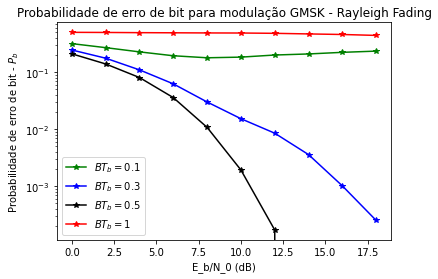

In [6]:
#gmsk com canal FIR
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import matplotlib.pyplot as plt
from scipy.signal import upfirdn,lfilter
from scipy.special import erfc
import scipy

fc = 800
OF = 16
N = 100000
L = 4
Tb = 2
a = np.random.randint(2, size=N)
BT = np.linspace(0, 2, num=10)

def rayleighFading(N):
    """
    Generate Rayleigh flat-fading channel samples
    Parameters:
        N : number of samples to generate
    Returns:
        abs_h : Rayleigh flat fading samples
    """
    # 1 tap complex gaussian filter
    h = 1/sqrt(2)*(standard_normal(N)+1j*standard_normal(N))
    return h

def gaussianLPF(BT, Tb, L, k):
  """
  Generate filter coefficients of Gaussian low pass filter (used in gmsk_mod)
  Parameters:
  BT : BT product - Bandwidth x bit period
  Tb : bit period
  L : oversampling factor (number of samples per bit)
  k : span length of the pulse (bit interval)
  Returns:
  h_norm : normalized filter coefficients of Gaussian LPF
  """
  B = BT/Tb # bandwidth of the filter
  # truncated time limits for the filter
  t = np.arange(start = -k*Tb, stop = k*Tb + Tb/L, step = Tb/L)
  h = B*np.sqrt(2*np.pi/(np.log(2)))*np.exp(-2 * (t*np.pi*B)**2 /(np.log(2)))
  h_norm=h/np.sum(h)
  return h_norm

# Função da Modulação

def gmsk_mod(a,fc,L,BT,enable_plot=False):
    """
    Function to modulate a binary stream using GMSK modulation
    Parameters:
        BT : BT product (bandwidth x bit period) for GMSK
        a : input binary data stream (0's and 1's) to modulate
        fc : RF carrier frequency in Hertz
        L : oversampling factor
        enable_plot: True = plot transmitter waveforms (default False)
    Returns:
        (s_t,s_complex) : tuple containing the following variables
            s_t : GMSK modulated signal with carrier s(t)
            s_complex : baseband GMSK signal (I+jQ)
    """ 
    fs = L*fc; Ts=1/fs;Tb = L*Ts; # derived waveform timing parameters
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L) #NRZ pulse train c(t)
    
    k=1 # truncation length for Gaussian LPF
    h_t = gaussianLPF(BT,Tb,L,k) # Gaussian LPF with BT=0.25
    b_t = np.convolve(h_t,c_t,'full') # convolve c(t) with Gaussian LPF to get b(t)
    bnorm_t = b_t/max(abs(b_t)) # normalize the output of Gaussian LPF to +/-1
    
    h = 0.5;
    # integrate to get phase information
    phi_t = lfilter(b = [1], a = [1,-1], x = bnorm_t*Ts) * h*np.pi/Tb 
    
    I = np.cos(phi_t)
    Q = np.sin(phi_t) # cross-correlated baseband I/Q signals
    
    s_complex = I - 1j*Q # complex baseband representation
    t = Ts* np.arange(start = 0, stop = len(I)) # time base for RF carrier
    sI_t = I*np.cos(2*np.pi*fc*t); sQ_t = Q*np.sin(2*np.pi*fc*t)
    s_t = sI_t - sQ_t # s(t) - GMSK with RF carrier
    
    if enable_plot:
        fig, axs = plt.subplots(2, 4)
        axs[0,0].plot(np.arange(0,len(c_t))*Ts,c_t);
        axs[0,0].set_title('c(t)');axs[0,0].set_xlim(0,40*Tb)
        axs[0,1].plot(np.arange(-k*Tb,k*Tb+Ts,Ts),h_t);
        axs[0,1].set_title('$h(t): BT_b$='+str(BT))
        axs[0,2].plot(t,I,'--');axs[0,2].plot(t,sI_t,'r');
        axs[0,2].set_title('$I(t)cos(2 \pi f_c t)$');axs[0,2].set_xlim(0,10*Tb)
        axs[0,3].plot(t,Q,'--');axs[0,3].plot(t,sQ_t,'r');
        axs[0,3].set_title('$Q(t)sin(2 \pi f_c t)$');axs[0,3].set_xlim(0,10*Tb)
        axs[1,0].plot( np.arange(0,len(bnorm_t))*Ts,bnorm_t);
        axs[1,0].set_title('b(t)');axs[1,0].set_xlim(0,40*Tb)
        axs[1,1].plot(np.arange(0,len(phi_t))*Ts, phi_t);
        axs[1,1].set_title('$\phi(t)$')
        axs[1,2].plot(t,s_t);axs[1,2].set_title('s(t)');
        axs[1,2].set_xlim(0,20*Tb)
        axs[1,3].plot(I,Q);axs[1,3].set_title('Constelação')
        fig.show()        
    return (s_t,s_complex)

def BER(x,b):                   #função da ber
  numErr = np.sum(abs(x - b))
  return numErr/len(x)

def awgn(s,SNRdB,L=1):         #canal awgn
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
        
    N0=P/gamma # Find the noise spectral density    
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal    
    return r
# Função da Demodulação
def gmsk_demod(r_complex,L):
  """
  Function to demodulate a baseband GMSK signal
  Parameters:
  r_complex : received signal at receiver front end (complex form - I+jQ)
  L : oversampling factor
  Returns:
  a_hat : detected binary stream
  """
  I = np.real(r_complex); Q = -np.imag(r_complex); # I,Q streams
  z1 = Q * np.hstack((np.zeros(L), I[0:len(I)-L]))
  z2 = I * np.hstack((np.zeros(L), Q[0:len(I)-L]))
  z = z1 - z2
  a_hat = (z[2*L-1:-L:L] > 0).astype(int) # sampling and hard decision
  #sampling indices depend on the truncation length (k) of Gaussian LPF defined in the modulator
  return a_hat

EbN0dB = np.arange(start=0,stop = 19, step = 2) # Eb/N0 range in dB for simulation
BTs = [0.1, 0.3 ,0.5, 1] # Gaussian LPF's BT products
#fc = 800 # Carrier frequency in Hz (must be < fs/2 and > fg)
#L = 16 # oversampling factor

fig, axs = plt.subplots(nrows=1,ncols = 1)
lineColors = ['g','b','k','r']

for i,BT in enumerate(BTs):
  a = np.random.randint(2, size=N) # símbolos 0 ou 1
  (s_t,s_complex) = gmsk_mod(a,fc,L,BT) # modulação gmsk
  BER = np.zeros(len(EbN0dB)) # valores de ber pra cada eb/n0
  for j,EbN0 in enumerate(EbN0dB):
    s_complex = scipy.signal.wiener(s_complex)
    r_complex = awgn(s_complex,EbN0) # awgn
   # r_complex = h.conj()/abs(h) ** 2 * r_complex      # equalizador LS
    a_hat = gmsk_demod(r_complex,L) # demodulação em banda básica
    BER[j] = np.sum(a!=a_hat)/N # computação ber
    
  axs.semilogy(EbN0dB,BER,lineColors[i]+'*-',label='$BT_b=$'+str(BT))

axs.set_title('Probabilidade de erro de bit para modulação GMSK - Rayleigh Fading')
axs.set_xlabel('E_b/N_0 (dB)');axs.set_ylabel('Probabilidade de erro de bit - $P_b$')
axs.legend();fig.show()